In [1]:
import json
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from itertools import combinations
import numpy as np

from traffic_detection_project.source.constants import DATASET_DIR, SOURCE_DIR

In [2]:
ANNOTATION_FILE = os.path.join(DATASET_DIR, "coco_all.json")

In [3]:
with open(ANNOTATION_FILE, "r") as file_handler:
    data = json.load(file_handler)

images_dict = {
    img["id"]: {
        "file_name": img.get("file_name", ""),
        "width": img.get("width", None),
        "height": img.get("height", None),
    }
    for img in data.get("images", [])
}

categories_dict = {cat["id"]: cat["name"] for cat in data.get("categories", [])}
annotations_list = data.get("annotations", [])

print(f"Amount of images: {len(images_dict)}")
print(f"Amount of categories: {len(categories_dict)}")
print(f"Amount of annotations: {len(annotations_list)}\n")

Amount of images: 7481
Amount of categories: 91
Amount of annotations: 39597



In [4]:
records = []
for annotation in annotations_list:
    img_id = annotation["image_id"]
    cat_id = annotation["category_id"]
    bbox = annotation.get("bbox", [0, 0, 0, 0])  # [x_min, y_min, width, height]
    x_min, y_min, w_box, h_box = bbox
    area_box = float(annotation["area"])
    aspect_ratio = float(w_box / h_box) if h_box > 0 else np.nan
    x_center = float(x_min + w_box / 2.0)
    y_center = float(y_min + h_box / 2.0)

    img_info = images_dict.get(img_id, {})
    fname = img_info.get("file_name", "")
    img_w = img_info.get("width", None)
    img_h = img_info.get("height", None)

    cat_name = categories_dict.get(cat_id, "unknown")

    records.append(
        {
            "image_id": img_id,
            "file_name": fname,
            "category_id": cat_id,
            "category_name": cat_name,
            "bbox_xmin": float(x_min),
            "bbox_ymin": float(y_min),
            "bbox_width": float(w_box),
            "bbox_height": float(h_box),
            "area": float(area_box),
            "aspect_ratio": float(aspect_ratio),
            "x_center": float(x_center),
            "y_center": float(y_center),
            "image_width": img_w,
            "image_height": img_h,
        }
    )

df = pd.DataFrame.from_records(records)

# Results


In [5]:
print(f"Amount of annotations: {len(df)}")
print(f"Amount of unique images with annotations: {df["image_id"].nunique()}")

Amount of annotations: 39597
Amount of unique images with annotations: 7481


## Categories

In [6]:
category_counts = df["category_name"].value_counts()
category_perc = (category_counts / len(df) * 100).round(2)
print(category_counts)
print(category_perc)

category_name
car       31656
person     6336
truck      1094
train       511
Name: count, dtype: int64
category_name
car       79.95
person    16.00
truck      2.76
train      1.29
Name: count, dtype: float64


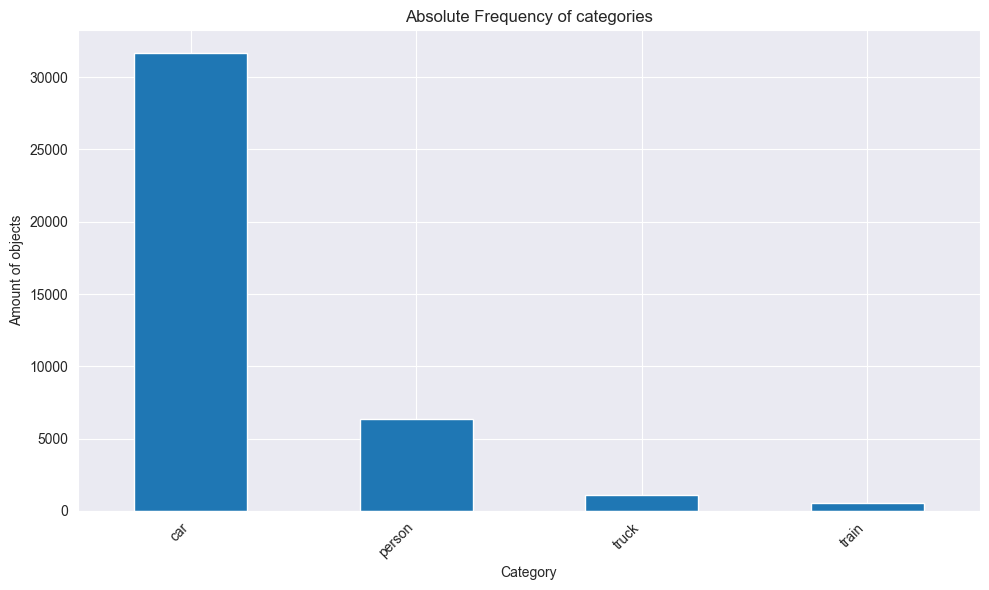

In [7]:
plt.figure(figsize=(10, 6))
category_counts.plot(kind="bar")
plt.title("Absolute Frequency of categories")
plt.xlabel("Category")
plt.ylabel("Amount of objects")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(os.path.join(SOURCE_DIR, "dataset_analysis", "Absolute Frequency of categories.png"))
plt.show()

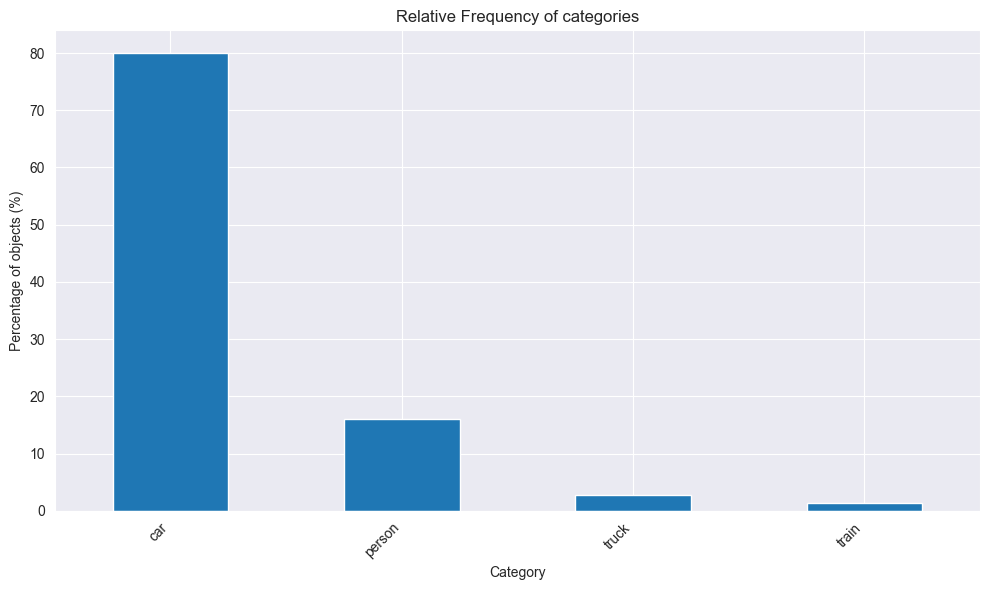

In [8]:
plt.figure(figsize=(10, 6))
category_perc.plot(kind="bar")
plt.title("Relative Frequency of categories")
plt.xlabel("Category")
plt.ylabel("Percentage of objects (%)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(os.path.join(SOURCE_DIR, "dataset_analysis", "Relative Frequency of categories.png"))
plt.show()

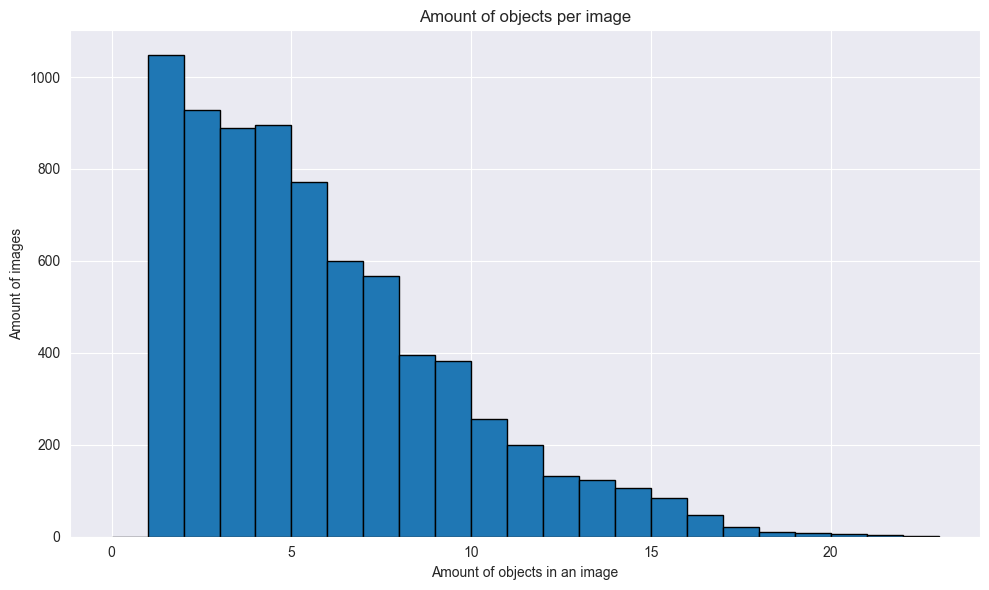

In [9]:
objs_per_image = df.groupby("image_id").size()
plt.figure(figsize=(10, 6))
plt.hist(objs_per_image, bins=range(int(objs_per_image.max()) + 2), edgecolor="black")
plt.title("Amount of objects per image")
plt.xlabel("Amount of objects in an image")
plt.ylabel("Amount of images")
plt.tight_layout()
plt.show()

In [10]:
print(f"Minimum amount of objects in an image: {int(objs_per_image.min())}")
print(f"Maximum amount of objects in an image: {int(objs_per_image.max())}")
print(f"Mean objects per image: {objs_per_image.mean():.2f}")
print(f"Median objects per image: {objs_per_image.median():.0f}\n")

Minimum amount of objects in an image: 1
Maximum amount of objects in an image: 22
Mean objects per image: 5.29
Median objects per image: 4



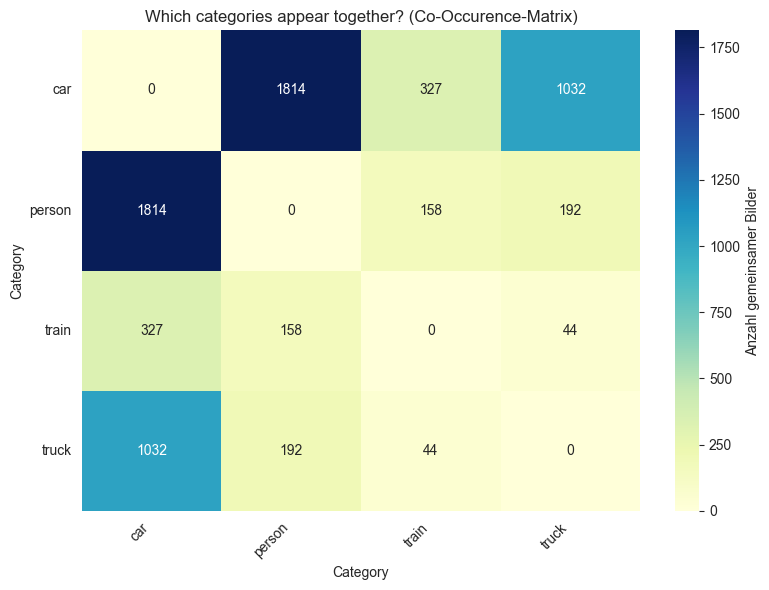

In [11]:
image_to_cats = df.groupby("image_id")["category_name"].apply(set)

all_cats = sorted(df["category_name"].unique())

co_matrix = pd.DataFrame(data=np.zeros((len(all_cats), len(all_cats)), dtype=int), index=all_cats, columns=all_cats)

for cats in image_to_cats:
    for c1, c2 in combinations(cats, 2):
        co_matrix.at[c1, c2] += 1
        co_matrix.at[c2, c1] += 1

plt.figure(figsize=(8, 6))
sns.heatmap(
    co_matrix,
    cmap="YlGnBu",
    annot=True,
    fmt="d",
    cbar_kws={"label": "Anzahl gemeinsamer Bilder"},
    xticklabels=True,
    yticklabels=True,
)
plt.title("Which categories appear together? (Co-Occurence-Matrix)")
plt.xlabel("Category")
plt.ylabel("Category")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Annotation boxes

In [12]:
bbox_cols = ["bbox_width", "bbox_height", "area", "aspect_ratio"]
print(df[bbox_cols].describe().round(2))

       bbox_width  bbox_height       area  aspect_ratio
count    39597.00     39597.00   39597.00      39597.00
mean       101.79        73.37   11110.16          1.48
std         88.69        57.09   18680.79          0.71
min          0.11        12.67       1.49          0.00
25%         39.78        33.10    1418.83          1.05
50%         69.11        52.47    3573.35          1.39
75%        132.09        94.24   11326.32          1.95
max        581.42       375.00  190706.34          4.36


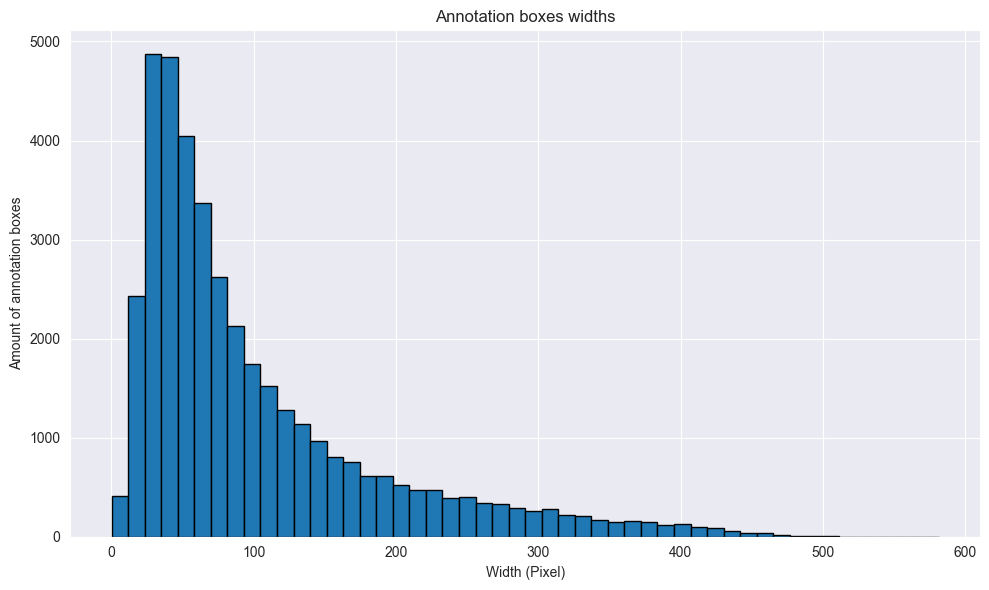

In [13]:
plt.figure(figsize=(10, 6))
plt.hist(df["bbox_width"], bins=50, edgecolor="black")
plt.title("Annotation boxes widths")
plt.xlabel("Width (Pixel)")
plt.ylabel("Amount of annotation boxes")
plt.tight_layout()
plt.show()

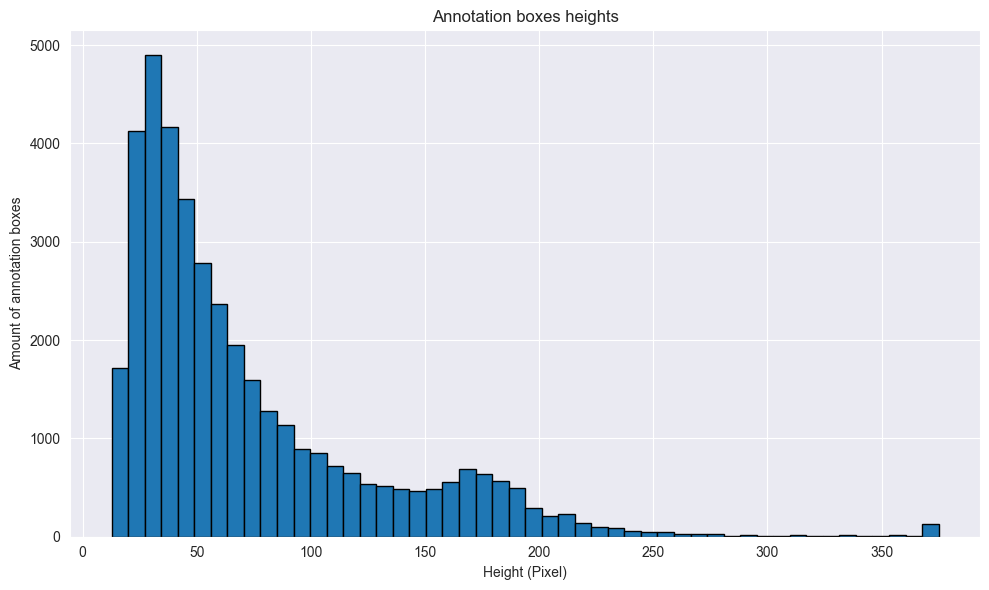

In [14]:
plt.figure(figsize=(10, 6))
plt.hist(df["bbox_height"], bins=50, edgecolor="black")
plt.title("Annotation boxes heights")
plt.xlabel("Height (Pixel)")
plt.ylabel("Amount of annotation boxes")
plt.tight_layout()
plt.show()

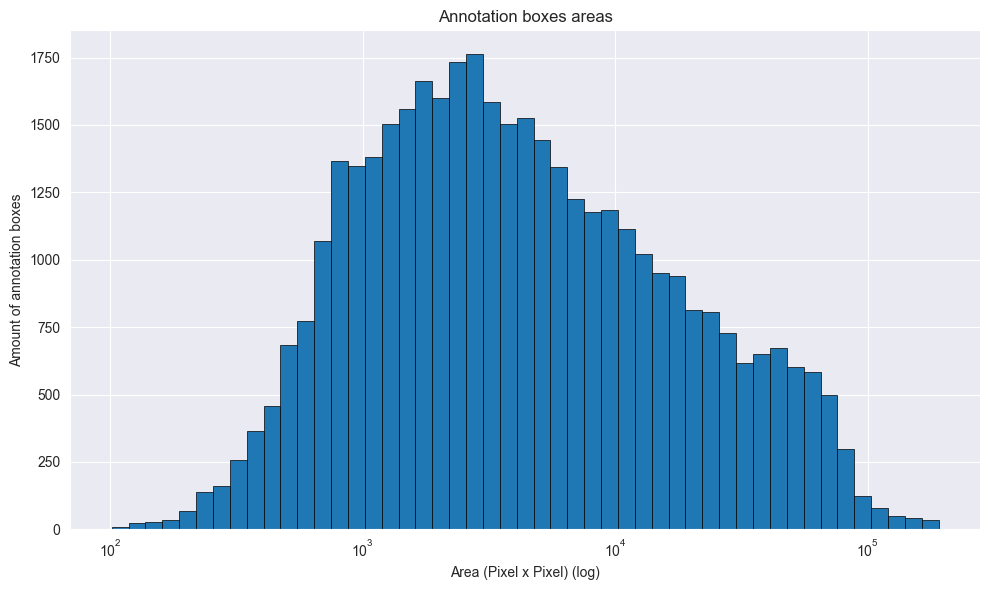

In [15]:
areas = df["area"].values

min_area = areas[areas > 100].min()
max_area = areas.max()

num_bins = 50
log_bins = np.logspace(np.log10(min_area), np.log10(max_area), num=num_bins)

plt.figure(figsize=(10, 6))
plt.hist(areas, bins=log_bins, edgecolor="black", linewidth=0.5)


plt.title("Annotation boxes areas")
plt.xlabel("Area (Pixel x Pixel) (log)")
plt.ylabel("Amount of annotation boxes")
plt.xscale("log")
plt.tight_layout()
plt.show()

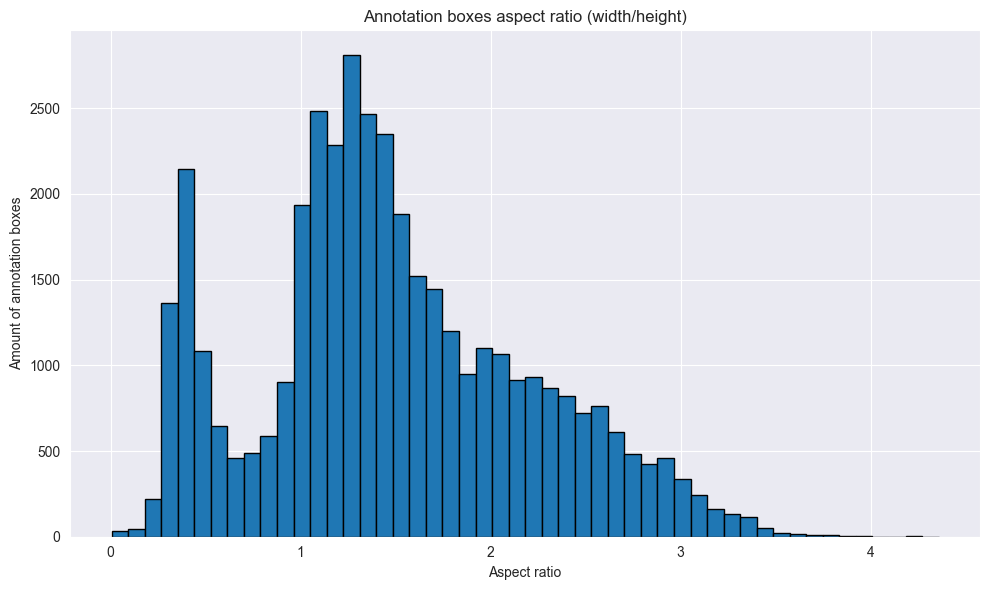

In [16]:
plt.figure(figsize=(10, 6))
plt.hist(df["aspect_ratio"].dropna(), bins=50, edgecolor="black")
plt.title("Annotation boxes aspect ratio (width/height)")
plt.xlabel("Aspect ratio")
plt.ylabel("Amount of annotation boxes")
plt.tight_layout()
plt.show()

In [17]:
small_threshold = 32 * 32
medium_threshold = 96 * 96

mask_small = df["area"] < small_threshold
mask_medium = (df["area"] >= small_threshold) & (df["area"] < medium_threshold)
mask_large = df["area"] >= medium_threshold

count_small = mask_small.sum()
count_medium = mask_medium.sum()
count_large = mask_large.sum()

total_boxes = len(df)

perc_small = (count_small / total_boxes) * 100
perc_medium = (count_medium / total_boxes) * 100
perc_large = (count_large / total_boxes) * 100

categories = ["small\n(< 32×32)", "medium\n(32×32 – 96×96)", "large\n(≥ 96×96)"]
abs_counts = [count_small, count_medium, count_large]
rel_perc = [perc_small, perc_medium, perc_large]

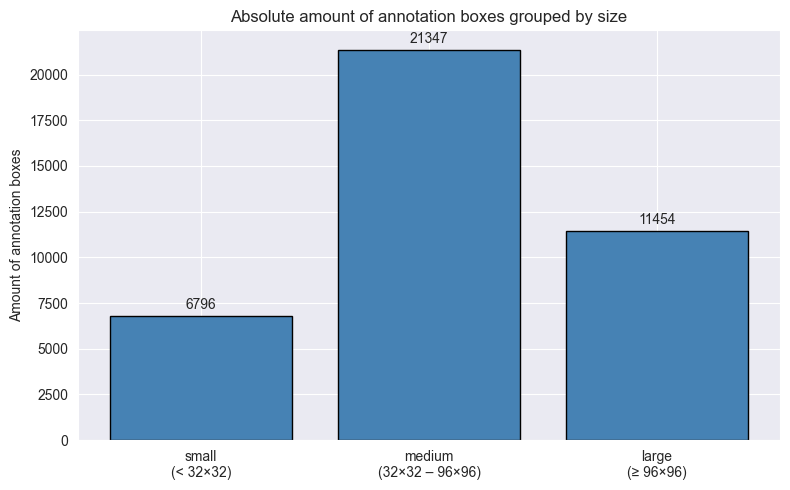

In [18]:
plt.figure(figsize=(8, 5))
bars1 = plt.bar(categories, abs_counts, color="steelblue", edgecolor="black")
plt.title("Absolute amount of annotation boxes grouped by size")
plt.ylabel("Amount of annotation boxes")
plt.xticks(rotation=0)

for bar in bars1:
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, h + total_boxes * 0.005, f"{int(h)}", ha="center", va="bottom", fontsize=10
    )
plt.tight_layout()
plt.show()

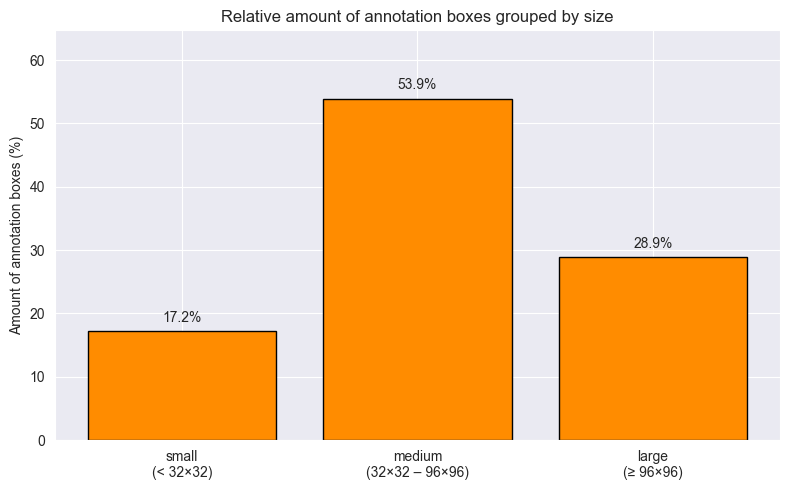

In [19]:
plt.figure(figsize=(8, 5))
bars2 = plt.bar(categories, rel_perc, color="darkorange", edgecolor="black")
plt.title("Relative amount of annotation boxes grouped by size")
plt.ylabel("Amount of annotation boxes (%)")
plt.xticks(rotation=0)
plt.ylim(0, max(rel_perc) * 1.2)

for bar, perc in zip(bars2, rel_perc):
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, h + 1, f"{perc:.1f}%", ha="center", va="bottom", fontsize=10)
plt.tight_layout()
plt.show()

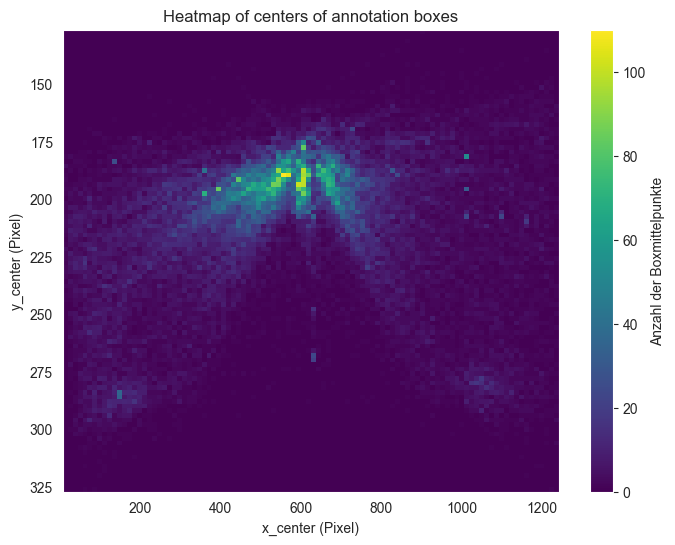

In [20]:
x = df["x_center"].values
y = df["y_center"].values

plt.figure(figsize=(8, 6))
counts, xedges, yedges, image = plt.hist2d(x, y, bins=[100, 100], cmap="viridis")
plt.colorbar(image, label="Anzahl der Boxmittelpunkte")
plt.title("Heatmap of centers of annotation boxes")
plt.xlabel("x_center (Pixel)")
plt.ylabel("y_center (Pixel)")
plt.gca().invert_yaxis()
plt.show()

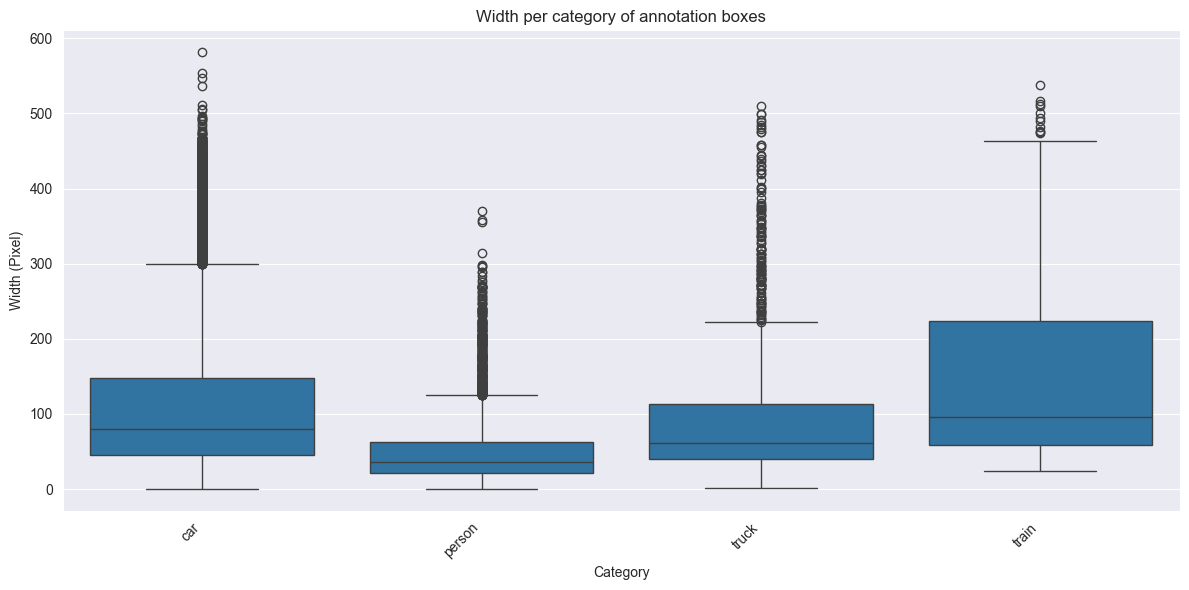

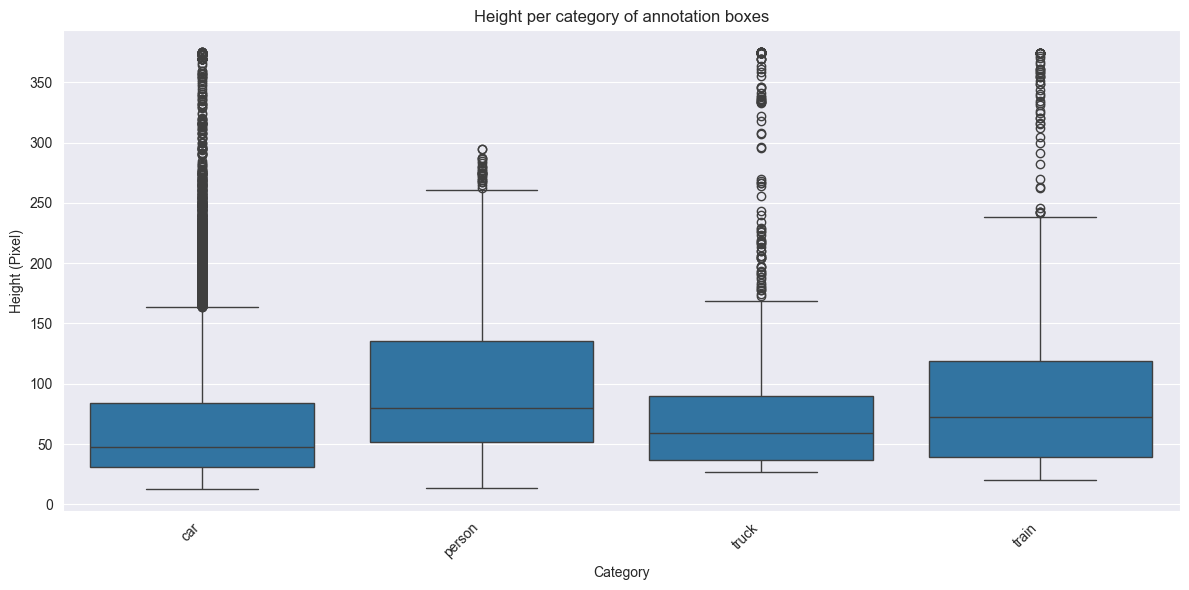

In [21]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="category_name", y="bbox_width", order=df["category_name"].value_counts().index)
plt.title("Width per category of annotation boxes")
plt.xlabel("Category")
plt.ylabel("Width (Pixel)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="category_name", y="bbox_height", order=df["category_name"].value_counts().index)
plt.title("Height per category of annotation boxes")
plt.xlabel("Category")
plt.ylabel("Height (Pixel)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()